In [1]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
from datetime import timezone
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from icelakes.utilities import convert_time_to_string
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, get_quality_summary, convert_time_to_string, read_melt_lake_h5

In [2]:
base_dir = 'detection_out_data/'
searchfor = '.h5'
# searchfor = 'ATL03_20190119174407_03400210_006'
searchdir = base_dir # + out_data_dir
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i data files.' % len(filelist))

for i in range(10):
    print(filelist[i])

There are 50 data files.
detection_out_data/lake_096345_GrIS_2023_simplified_GRE_2000_CW_ATL03_20230806063138_07192003_006_02_gt3l_0025.h5
detection_out_data/lake_096361_GrIS_2023_simplified_GRE_2000_CW_ATL03_20230806063138_07192003_006_02_gt3r_0028.h5
detection_out_data/lake_099091_GrIS_2023_simplified_GRE_2000_SW_ATL03_20230806063138_07192003_006_02_gt3r_0020.h5
detection_out_data/lake_099266_GrIS_2023_simplified_GRE_2000_CW_ATL03_20230806063138_07192003_006_02_gt1l_0005.h5
detection_out_data/lake_099323_GrIS_2023_simplified_GRE_2000_CW_ATL03_20230806063138_07192003_006_02_gt2r_0020.h5
detection_out_data/lake_099329_GrIS_2023_simplified_GRE_2000_SW_ATL03_20230806063138_07192003_006_02_gt1l_0002.h5
detection_out_data/lake_099456_GrIS_2023_simplified_GRE_2000_SW_ATL03_20230806063138_07192003_006_02_gt3l_0013.h5
detection_out_data/lake_099520_GrIS_2023_simplified_GRE_2000_CW_ATL03_20230806063138_07192003_006_02_gt1l_0006.h5
detection_out_data/lake_099576_GrIS_2023_simplified_GRE_2000_SW

In [3]:
###########################################################################
def read_lake_file(fn):
    lakedict = {}
    with h5py.File(fn, 'r') as f:
        # metadata
        for key in f['properties'].keys(): 
            lakedict[key] = f['properties'][key][()]
            if f['properties'][key].dtype == object:
                lakedict[key] = lakedict[key].decode('utf-8')
        names = ['depth_data', 'photon_data']
        for name in names:
            d = {}
            for key in f[name].keys():
                d[key] = f[name][key][()]
            lakedict[name] = pd.DataFrame(d)
    return lakedict

In [4]:
# ! rm -f detection_out_data/*_GrIS_2023_teslake_gris_bounding_box*.h5

In [5]:
fl = [x for x in filelist if 'GrIS_2023_teslake_gris_bounding_box_ATL03_20230806063138_07192003_006_02_gt3r_0003.h5' in x]
# fl = [x for x in filelist if 'GrIS_2023_teslake_gris_bounding_box_ATL03_20230806063138_07192003_006_02_gt3r' in x]
# fl = [x for x in filelist if 'GrIS_2023_teslake_gris_bounding_box_ATL03_20230806063138_07192003_006_02' in x]

fl

[]

In [12]:
def plot_lake_detail(self, closefig=True):
    try:
        dfp = self.photon_data
        dfd = self.depth_data
        dfm = self.mframe_data
        surf_elev = self.surface_elevation
        max_depth = self.max_depth
        refract_idx = 1.336
    
        fig, axs = plt.subplots(figsize=[21,13], dpi=50, ncols=3, nrows=4, sharex=True, sharey=True)
        axs = axs.flatten()
        sz_scatt = 15
        inset_loc = [0.01, 0.04, 0.02, 0.4]
        inset_sz = 8
        textbox = dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', edgecolor='none')
    
        maxd_rng = np.max((max_depth, 2.0))
        yl = (surf_elev-2*maxd_rng*refract_idx, surf_elev+maxd_rng*refract_idx)
        xl = (0, dfp.xatc.max())
        daxs = []
    
        ##############################################################
        # INFO TEXT
        ax = axs[1]
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        try:
            txt0 = 'ICESat-2 lake data:'
            ax.text(0.5, 0.98, txt0, transform=ax.transAxes, va='top', ha='center', fontsize=15)
            txt = 'granule_id = %s\n' % self.granule_id
            txt += 'cycle_number = %s, rgt = %s, gtx = %s, sc_orient = %s\n' % (self.cycle_number, self.rgt, self.gtx, self.sc_orient)
            txt += 'beam_number = %s, beam_strength = %s\n' % (self.beam_number, self.beam_strength)
            txt += 'ice_sheet = %s, melt_season = %s\n' % (self.ice_sheet, self.melt_season)
            txt += 'polygon_filename = %s\n' % self.polygon_filename
            txt += 'date_time = %s UTC\n' % self.date_time
            txt += 'lat_str = %s, lon_str = %s\n' % (self.lat_str, self.lon_str)
            txt += 'bbox = [%.5f, %.5f, %.5f, %.5f]\n' % (self.lon_min, self.lat_min, self.lon_max, self.lat_max)
            txt += 'surface_elevation = %.1f m, max_depth = %.1f m\n' % (self.surface_elevation, self.max_depth)
            txt += 'depth_quality_sort = %.3f' % (self.depth_quality_sort)
            
            ax.text(0.5, 0.5, txt, transform=ax.transAxes, va='center', ha='center', fontsize=12)
            txt2 = 'lake_id = %s\n' % self.lake_id
            ax.text(0.5, 0.01, txt2, transform=ax.transAxes, va='bottom', ha='center', fontsize=9)
            ax.axis('off')
        except:
            traceback.print_exc()
    
        ##############################################################
        # RAW ATL03
        ax = axs[0]
        try:
            ax.text(0.5, 0.9, 'raw ATL03 data', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            ax.scatter(dfp.xatc, dfp.h, s=sz_scatt, color='k', edgecolors='none')
        except:
            traceback.print_exc()
    
        ##############################################################
        # FITTED SURFACE / LAKEBED
        ax = axs[2]
        conf_thresh = 0.3
        try:
            ax.text(0.5, 0.9, 'fitted surface / lakebed', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            dfp_plot = dfp.copy()
            dfp_plot = dfp_plot[~dfp_plot.is_afterpulse]
            ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, color='gray', edgecolors='none')
            # ax.scatter(dfp.xatc[dfp.is_afterpulse], dfp.h[dfp.is_afterpulse], s=sz_scatt*4, color='g')
            hfitsurf = dfd.h_fit_surf.copy()
            hfitsurf[dfd.depth <= 0] = np.nan
            p_surf, = ax.plot(dfd.xatc, hfitsurf, color='C0', lw=3, label='surface')
            hfitbed = dfd.h_fit_bed.copy()
            hfitbed[dfd.depth <= 0] = np.nan
            p_bed, = ax.plot(dfd.xatc, hfitbed, color='r', lw=1, ls='--', label='lakebed fit')
            hfitbed[dfd.conf <= conf_thresh] = np.nan
            hfitbed[dfd.h_fit_bed > (surf_elev-0.1)] = np.nan
            p_bed2, = ax.plot(dfd.xatc, hfitbed, color='r', lw=3, label='lakebed conf > %g'%conf_thresh)
            h0 = self.surface_elevation
            def h2d(h):
                return (h0 - h) / refract_idx
            def d2h(d):
                return h0 - d * refract_idx 
            ylm = yl
            dax = ax.twinx()
            dax.set_ylim([h2d(ylm[0]), h2d(ylm[1])])
            xl = ax.get_xlim()
            ax.plot([xl[1]]*2, [h0, h0-refract_idx*max_depth], 'r-', lw=3)
            daxs.append(dax)
            ax.text(0.03, 0.04, 'lake quality: %.2f' % self.depth_quality_sort, transform=ax.transAxes, va='bottom', ha='left', fontsize=17, bbox=textbox,
                    fontweight='bold', color='r')
            leg1 = ax.legend(handles=[p_surf, p_bed, p_bed2], loc='lower right',fontsize=8)
        except:
            traceback.print_exc()
    
        ##############################################################
        # PHOTON SIGNAL CONFIDENCE / SNR
        ax = axs[3]
        try:
            ax.text(0.5, 0.9, 'photon signal confidence', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            dfp_plot = dfp.copy().sort_values(by='snr').reset_index(drop=True)
            scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.snr, cmap=cmc.lajolla, edgecolors='none',vmin=0,vmax=1)
            cax = ax.inset_axes(inset_loc)
            cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
            cax.tick_params(axis='both', which='major', labelsize=inset_sz)
        except:
            traceback.print_exc()
    
        ##############################################################
        # BED PROBABILITY
        try:
            import matplotlib.colors as colors
            def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
                new_cmap = colors.LinearSegmentedColormap.from_list(
                    'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                    cmap(np.linspace(minval, maxval, n)))
                return new_cmap
        except:
            traceback.print_exc()
        
        ax = axs[4]
        try:
            ax.text(0.5, 0.9, 'lakebed probability', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            dfp_plot = dfp.copy().sort_values(by='prob_bed').reset_index(drop=True)
            thiscmap = truncate_colormap(cmc.vik, minval=0.5, maxval=1.0)
            scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.prob_bed, edgecolors='none', cmap=thiscmap, vmin=0, vmax=1)
            cax = ax.inset_axes(inset_loc)
            cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
            cax.tick_params(axis='both', which='major', labelsize=inset_sz)
        except:
            traceback.print_exc()
    
        ##############################################################
        # SURFACE PROBABILITY
        ax = axs[7]
        try:
            ax.text(0.5, 0.9, 'surface probability', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            dfp_plot = dfp.copy().sort_values(by='prob_surf').reset_index(drop=True)
            thiscmap = truncate_colormap(cmc.vik_r, minval=0.5, maxval=1.0)
            scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.prob_surf, edgecolors='none', cmap=thiscmap, vmin=0, vmax=1)
            cax = ax.inset_axes(inset_loc)
            cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
            cax.tick_params(axis='both', which='major', labelsize=inset_sz)
        except:
            traceback.print_exc()
        
        ##############################################################
        # BATHYMETRY CONFIDENCE
        ax = axs[5]
        try:
            ax.text(0.5, 0.9, 'bathymetry confidence', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            dax = ax.twinx()
            dax.set_ylim([h2d(ylm[0]), h2d(ylm[1])])
            xl = ax.get_xlim()
            dax.plot(xl, [0]*2, 'k--')
            scatt = dax.scatter(dfd.xatc, dfd.depth, s=1+dfd.conf*50, c=dfd.conf, edgecolors='none', cmap=cmc.batlowW_r, vmin=0, vmax=1)
            cax = ax.inset_axes(inset_loc)
            cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
            cax.tick_params(axis='both', which='major', labelsize=inset_sz)
            xl = ax.get_xlim()
            ax.plot([xl[1]]*2, [h0, h0-refract_idx*max_depth], 'r-', lw=3)
            daxs.append(dax)
        except:
            traceback.print_exc()
    
        ##############################################################
        # PULSE SATURATION
        ax = axs[10]
        try:
            ax.text(0.5, 0.9, 'pulse saturation', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            dfp_plot = dfp.copy().sort_values(by='sat_ratio').reset_index(drop=True)
            scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.sat_ratio, cmap=cmc.nuuk_r, edgecolors='none',vmin=0,vmax=5)
            dfp_plot.loc[(dfp_plot.sat_elev==0) | (dfp_plot.sat_ratio<1), 'sat_elev'] = np.nan
            h_sat = dfp_plot.groupby(['mframe', 'ph_id_pulse'])[['xatc', 'sat_elev']].mean()
            scatt_h = ax.scatter(h_sat.xatc, h_sat.sat_elev, s=sz_scatt/3, color='r', edgecolors='none', label='saturated surface returns')
            cax = ax.inset_axes(inset_loc)
            cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
            cax.tick_params(axis='both', which='major', labelsize=inset_sz)
            leg1 = ax.legend(handles=[scatt_h], loc='lower right',fontsize=10)
        except:
            traceback.print_exc()
    
        ##############################################################
        # AFTERPULSE PROBABILITY
        ax = axs[11]
        try:
            ax.text(0.5, 0.9, 'afterpulse probability', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            dfp_plot = dfp.copy().sort_values(by='prob_afterpulse').reset_index(drop=True)
            scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.prob_afterpulse, cmap=cmc.tokyo_r, edgecolors='none',vmin=0,vmax=1)
            cax = ax.inset_axes(inset_loc)
            cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
            cax.tick_params(axis='both', which='major', labelsize=inset_sz)
        except:
            traceback.print_exc()
    
        ##############################################################
        # FLATNESS CHECK
        ax = axs[6]
        try:
            ax.text(0.5, 0.9, 'flatness check', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            ax.scatter(dfp.xatc, dfp.h, s=sz_scatt/3, color='k', edgecolors='none')
            lns = []
            for i in range(len(dfm)-1):
                ln = (dfm.iloc[i].xatc_max + dfm.iloc[i+1].xatc_min) / 2
                ax.plot([ln]*2, ylm, 'k-', lw=0.7)
                lns.append(ln)
            is_flat_list = list(dfm.is_flat)
            bounds = [dfp.xatc.min()] + lns + [dfp.xatc.max()]
            hdls = [0, 0]
            for i, is_flat in enumerate(is_flat_list):
                thiscol = 'g' if is_flat else 'r'
                thishatch = '///' if is_flat else 'XXX'
                label = 'pass' if is_flat else 'fail'
                j = 0 if is_flat else 1
                hdl = ax.fill_between([bounds[i], bounds[i+1]], ylm[0], ylm[1], facecolor="none", hatch=thishatch, edgecolor=thiscol, 
                                            linewidth=1, alpha=0.3, label=label, zorder=-100)
                hdls[j] = hdl
            leg1 = ax.legend(handles=hdls, loc='lower left',fontsize=10)
        except:
            traceback.print_exc()
    
        ##############################################################
        # BATHYMETRY CHECK
        ax = axs[9]
        try:
            ax.text(0.5, 0.9, 'bathymetry check', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            ax.scatter(dfp.xatc, dfp.h, s=sz_scatt/3, color='k', edgecolors='none')
            lns = []
            for i in range(len(dfm)-1):
                ln = (dfm.iloc[i].xatc_max + dfm.iloc[i+1].xatc_min) / 2
                ax.plot([ln]*2, ylm, 'k-', lw=0.7)
                lns.append(ln)
            is_lake_list = list(dfm.lake_qual_pass)
            bounds = [dfp.xatc.min()] + lns + [dfp.xatc.max()]
            hdls = [0, 0]
            for i, is_lake in enumerate(is_lake_list):
                thiscol = 'g' if is_lake else 'r'
                thishatch = '///' if is_lake else 'XXX'
                label = 'pass' if is_lake else 'fail'
                j = 0 if is_lake else 1
                hdl = ax.fill_between([bounds[i], bounds[i+1]], ylm[0], ylm[1], facecolor="none", hatch=thishatch, edgecolor=thiscol, 
                                            linewidth=1, alpha=0.3, label=label, zorder=-100)
                hdls[j] = hdl
            leg1 = ax.legend(handles=hdls, loc='lower left',fontsize=10)
        except:
            traceback.print_exc()
    
        ##############################################################
        # BATHYMETRIC PEAKS FROM DETECTION
        ax = axs[8]
        try:
            ax.text(0.5, 0.9, 'detected bathymetry peaks', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
            dfb = pd.DataFrame(self.detection_2nd_returns)
            ax.scatter(dfp.xatc, dfp.h, s=sz_scatt/3, color='gray', edgecolors='none')
            ax.scatter(dfb.xatc, dfb.h, s=dfb.prom*180, edgecolors='b', facecolors='none', linewidth=0.5)
            prom100 = ax.scatter(-9999, -9999, s=1*50, edgecolors='b', facecolors='none', linewidth=1, label='prominence = 1.0')
            prom50 = ax.scatter(-9999, -9999, s=0.5*50, edgecolors='b', facecolors='none', linewidth=1, label='prominence = 0.5')
            prom20 = ax.scatter(-9999, -9999, s=0.2*50, edgecolors='b', facecolors='none', linewidth=1, label='prominence = 0.2')
            leg1 = ax.legend(handles=[prom100, prom50, prom20], loc='lower left',fontsize=10)
        except:
            traceback.print_exc()
    
        try:
            dfp['x10'] = np.round(dfp.xatc, -1)
            gt = dfp.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()
            
            # add latitude
            lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat','lon']].reset_index(drop=True)
            _lat = np.array(lx.lat)
            _lon = np.array(lx.lon)
            _xatc = np.array(lx.x10)
            def lat2xatc(l):
                return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
            def xatc2lat(x):
                return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
            def lon2xatc(l):
                return _xatc[0] + (l - _lon[0]) * (_xatc[1] - _xatc[0]) /(_lon[1] - _lon[0])
            def xatc2lon(x):
                return _lon[0] + (x - _xatc[0]) * (_lon[1] - _lon[0]) / (_xatc[1] - _xatc[0])
    
            for i,ax in enumerate(axs):
                if i%3 == 0:
                    ax.set_ylabel('elevation (m)')
                    ax.ticklabel_format(useOffset=False, style='plain')
                if i >= 9:
                    ax.set_xlabel('along-track distance (m)\n\n\n\n\n\n', labelpad=0)
                    ax.tick_params(axis='both', which='major', pad=0)
                    ax.ticklabel_format(useOffset=False, style='plain')
                    ax2 = ax.secondary_xaxis(-0.15, functions=(xatc2lat, lat2xatc))
                    ax2.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
                    ax2.set_xlabel('latitude',labelpad=0, fontsize=8)
                    ax2.tick_params(axis='both', which='major', pad=0)
                    ax2.xaxis.set_tick_params(labelsize=8)
                    ax2.ticklabel_format(useOffset=False, style='plain')
                    ax3 = ax.secondary_xaxis(-0.27, functions=(xatc2lon, lon2xatc))
                    ax3.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
                    ax3.set_xlabel('longitude',labelpad=0, fontsize=8)
                    ax3.tick_params(axis='both', which='major', pad=0)
                    ax3.xaxis.set_tick_params(labelsize=8)
                    ax3.ticklabel_format(useOffset=False, style='plain')
        except:
            traceback.print_exc()
        
        ax.set_ylim(yl)

        try:
            for dax in daxs:
                yticks = dax.get_yticks()
                yticks = yticks[yticks >= 0]
                dax.set_yticks(yticks)
                dax.tick_params(axis='y', colors='red')
                dax.set_ylim([h2d(yl[0]), h2d(yl[1])])
                dax.text(0.99, 0.66, 'water depth (m)', rotation=-90, color='r', fontweight='bold', va='top', ha='right', transform=dax.transAxes, bbox=textbox)
        except:
            traceback.print_exc()
            
        fig.tight_layout(w_pad=0.2, h_pad=0.2, pad=0.3)

        if closefig:
            plt.close(fig)
        return fig

    except:
        traceback.print_exc()

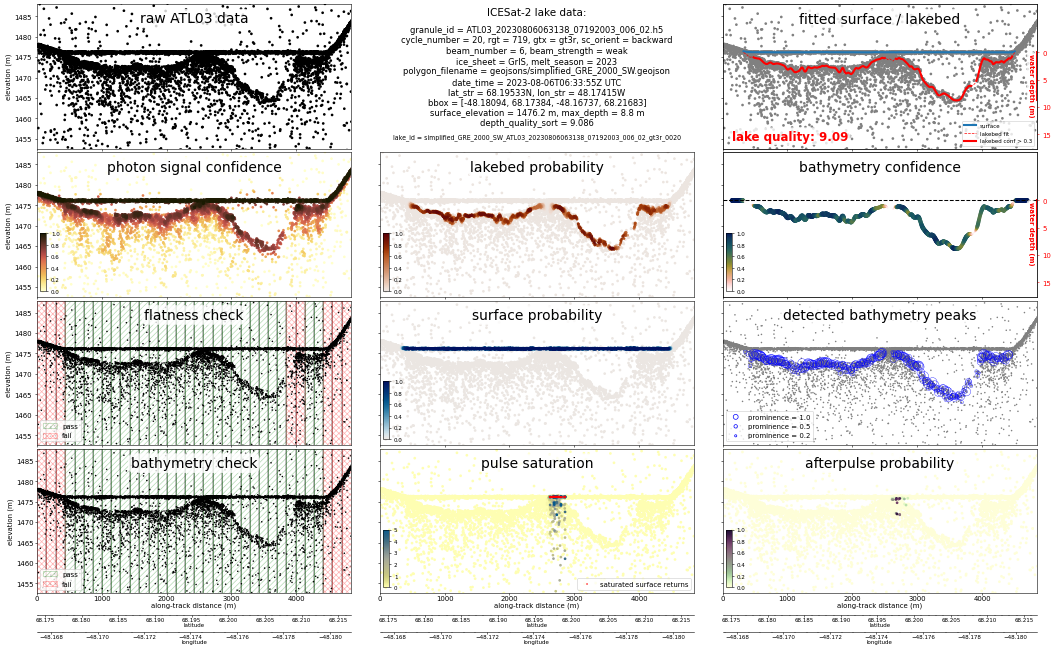

In [14]:
fig = plot_lake_detail(lk)
display(fig)

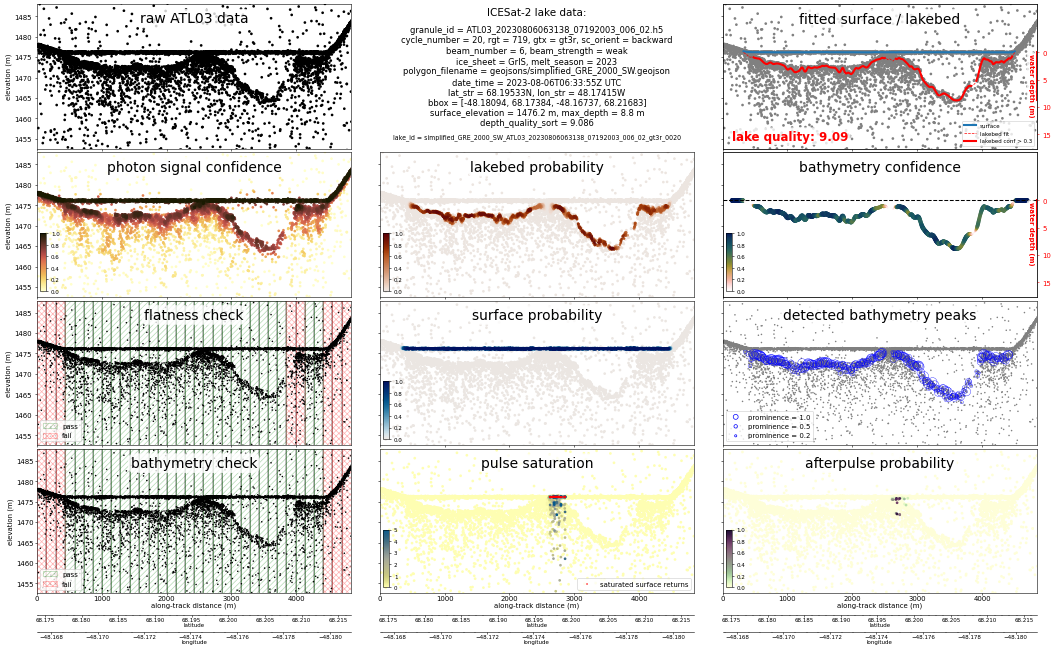

In [10]:
plt.close('all')
ix = 2
l = 1
# for i,fn in enumerate(filelist):
for i,fn in enumerate(filelist[ix:ix+l]):
# for i, fn in enumerate(fl):
    try:
        lk = dictobj(read_melt_lake_h5(fn))
    
        dfp = lk.photon_data
        dfd = lk.depth_data
        dfm = lk.mframe_data
        surf_elev = lk.surface_elevation
        max_depth = lk.max_depth
        refract_idx = 1.336
    
        fig, axs = plt.subplots(figsize=[21,13], dpi=50, ncols=3, nrows=4, sharex=True, sharey=True)
        axs = axs.flatten()
        sz_scatt = 15
        inset_loc = [0.01, 0.04, 0.02, 0.4]
        inset_sz = 8
        textbox = dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', edgecolor='none')
    
        maxd_rng = np.max((max_depth, 2.0))
        yl = (surf_elev-2*maxd_rng*refract_idx, surf_elev+maxd_rng*refract_idx)
        xl = (0, dfp.xatc.max())
    
        ##############################################################
        # INFO TEXT
        ax = axs[1]
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        txt0 = 'ICESat-2 lake data:'
        ax.text(0.5, 0.98, txt0, transform=ax.transAxes, va='top', ha='center', fontsize=15)
        txt = 'granule_id = %s\n' % lk.granule_id
        txt += 'cycle_number = %s, rgt = %s, gtx = %s, sc_orient = %s\n' % (lk.cycle_number, lk.rgt, lk.gtx, lk.sc_orient)
        txt += 'beam_number = %s, beam_strength = %s\n' % (lk.beam_number, lk.beam_strength)
        txt += 'ice_sheet = %s, melt_season = %s\n' % (lk.ice_sheet, lk.melt_season)
        txt += 'polygon_filename = %s\n' % lk.polygon_filename
        txt += 'date_time = %s UTC\n' % lk.date_time
        txt += 'lat_str = %s, lon_str = %s\n' % (lk.lat_str, lk.lon_str)
        txt += 'bbox = [%.5f, %.5f, %.5f, %.5f]\n' % (lk.lon_min, lk.lat_min, lk.lon_max, lk.lat_max)
        txt += 'surface_elevation = %.1f m, max_depth = %.1f m\n' % (lk.surface_elevation, lk.max_depth)
        txt += 'depth_quality_sort = %.3f' % (lk.depth_quality_sort)
        
        ax.text(0.5, 0.5, txt, transform=ax.transAxes, va='center', ha='center', fontsize=12)
        txt2 = 'lake_id = %s\n' % lk.lake_id
        ax.text(0.5, 0.01, txt2, transform=ax.transAxes, va='bottom', ha='center', fontsize=9)
        ax.axis('off')
    
        ##############################################################
        # RAW ATL03
        ax = axs[0]
        ax.text(0.5, 0.9, 'raw ATL03 data', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        ax.scatter(dfp.xatc, dfp.h, s=sz_scatt, color='k', edgecolors='none')
    
        ##############################################################
        # FITTED SURFACE / LAKEBED
        ax = axs[2]
        conf_thresh = 0.3
        ax.text(0.5, 0.9, 'fitted surface / lakebed', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        dfp_plot = dfp.copy()
        dfp_plot = dfp_plot[~dfp_plot.is_afterpulse]
        ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, color='gray', edgecolors='none')
        # ax.scatter(dfp.xatc[dfp.is_afterpulse], dfp.h[dfp.is_afterpulse], s=sz_scatt*4, color='g')
        hfitsurf = dfd.h_fit_surf.copy()
        hfitsurf[dfd.depth <= 0] = np.nan
        p_surf, = ax.plot(dfd.xatc, hfitsurf, color='C0', lw=3, label='surface')
        hfitbed = dfd.h_fit_bed.copy()
        hfitbed[dfd.depth <= 0] = np.nan
        p_bed, = ax.plot(dfd.xatc, hfitbed, color='r', lw=1, ls='--', label='lakebed fit')
        hfitbed[dfd.conf <= conf_thresh] = np.nan
        hfitbed[dfd.h_fit_bed > (surf_elev-0.1)] = np.nan
        p_bed2, = ax.plot(dfd.xatc, hfitbed, color='r', lw=3, label='lakebed conf > %g'%conf_thresh)
        h0 = lk.surface_elevation
        def h2d(h):
            return (h0 - h) / refract_idx
        def d2h(d):
            return h0 - d * refract_idx 
        ylm = yl
        daxs = []
        dax = ax.twinx()
        dax.set_ylim([h2d(ylm[0]), h2d(ylm[1])])
        xl = ax.get_xlim()
        ax.plot([xl[1]]*2, [h0, h0-refract_idx*max_depth], 'r-', lw=3)
        daxs.append(dax)
        ax.text(0.03, 0.04, 'lake quality: %.2f' % lk.depth_quality_sort, transform=ax.transAxes, va='bottom', ha='left', fontsize=17, bbox=textbox,
                fontweight='bold', color='r')
        leg1 = ax.legend(handles=[p_surf, p_bed, p_bed2], loc='lower right',fontsize=8)
        
    
        ##############################################################
        # PHOTON SIGNAL CONFIDENCE / SNR
        ax = axs[3]
        ax.text(0.5, 0.9, 'photon signal confidence', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        dfp_plot = dfp.copy().sort_values(by='snr').reset_index(drop=True)
        scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.snr, cmap=cmc.lajolla, edgecolors='none',vmin=0,vmax=1)
        cax = ax.inset_axes(inset_loc)
        cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
        cax.tick_params(axis='both', which='major', labelsize=inset_sz)
    
        ##############################################################
        # BED PROBABILITY
        import matplotlib.colors as colors
        def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
            new_cmap = colors.LinearSegmentedColormap.from_list(
                'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                cmap(np.linspace(minval, maxval, n)))
            return new_cmap
        
        ax = axs[4]
        ax.text(0.5, 0.9, 'lakebed probability', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        dfp_plot = dfp.copy().sort_values(by='prob_bed').reset_index(drop=True)
        thiscmap = truncate_colormap(cmc.vik, minval=0.5, maxval=1.0)
        scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.prob_bed, edgecolors='none', cmap=thiscmap, vmin=0, vmax=1)
        cax = ax.inset_axes(inset_loc)
        cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
        cax.tick_params(axis='both', which='major', labelsize=inset_sz)
    
        ##############################################################
        # SURFACE PROBABILITY
        ax = axs[7]
        ax.text(0.5, 0.9, 'surface probability', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        dfp_plot = dfp.copy().sort_values(by='prob_surf').reset_index(drop=True)
        thiscmap = truncate_colormap(cmc.vik_r, minval=0.5, maxval=1.0)
        scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.prob_surf, edgecolors='none', cmap=thiscmap, vmin=0, vmax=1)
        cax = ax.inset_axes(inset_loc)
        cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
        cax.tick_params(axis='both', which='major', labelsize=inset_sz)
        
        ##############################################################
        # BATHYMETRY CONFIDENCE
        ax = axs[5]
        ax.text(0.5, 0.9, 'bathymetry confidence', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        dax = ax.twinx()
        dax.set_ylim([h2d(ylm[0]), h2d(ylm[1])])
        xl = ax.get_xlim()
        dax.plot(xl, [0]*2, 'k--')
        scatt = dax.scatter(dfd.xatc, dfd.depth, s=1+dfd.conf*50, c=dfd.conf, edgecolors='none', cmap=cmc.batlowW_r, vmin=0, vmax=1)
        cax = ax.inset_axes(inset_loc)
        cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
        cax.tick_params(axis='both', which='major', labelsize=inset_sz)
        xl = ax.get_xlim()
        ax.plot([xl[1]]*2, [h0, h0-refract_idx*max_depth], 'r-', lw=3)
        daxs.append(dax)
    
        ##############################################################
        # PULSE SATURATION
        ax = axs[10]
        ax.text(0.5, 0.9, 'pulse saturation', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        dfp_plot = dfp.copy().sort_values(by='sat_ratio').reset_index(drop=True)
        scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.sat_ratio, cmap=cmc.nuuk_r, edgecolors='none',vmin=0,vmax=5)
        dfp_plot.loc[(dfp_plot.sat_elev==0) | (dfp_plot.sat_ratio<1), 'sat_elev'] = np.nan
        h_sat = dfp_plot.groupby(['mframe', 'ph_id_pulse'])[['xatc', 'sat_elev']].mean()
        scatt_h = ax.scatter(h_sat.xatc, h_sat.sat_elev, s=sz_scatt/3, color='r', edgecolors='none', label='saturated surface returns')
        cax = ax.inset_axes(inset_loc)
        cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
        cax.tick_params(axis='both', which='major', labelsize=inset_sz)
        leg1 = ax.legend(handles=[scatt_h], loc='lower right',fontsize=10)
        
    
        ##############################################################
        # AFTERPULSE PROBABILITY
        ax = axs[11]
        ax.text(0.5, 0.9, 'afterpulse probability', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        dfp_plot = dfp.copy().sort_values(by='prob_afterpulse').reset_index(drop=True)
        scatt = ax.scatter(dfp_plot.xatc, dfp_plot.h, s=sz_scatt, c=dfp_plot.prob_afterpulse, cmap=cmc.tokyo_r, edgecolors='none',vmin=0,vmax=1)
        cax = ax.inset_axes(inset_loc)
        cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
        cax.tick_params(axis='both', which='major', labelsize=inset_sz)
    
        ##############################################################
        # FLATNESS CHECK
        ax = axs[6]
        ax.text(0.5, 0.9, 'flatness check', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        ax.scatter(dfp.xatc, dfp.h, s=sz_scatt/3, color='k', edgecolors='none')
        lns = []
        for i in range(len(dfm)-1):
            ln = (dfm.iloc[i].xatc_max + dfm.iloc[i+1].xatc_min) / 2
            ax.plot([ln]*2, ylm, 'k-', lw=0.7)
            lns.append(ln)
        is_flat_list = list(dfm.is_flat)
        bounds = [dfp.xatc.min()] + lns + [dfp.xatc.max()]
        hdls = [0, 0]
        for i, is_flat in enumerate(is_flat_list):
            thiscol = 'g' if is_flat else 'r'
            thishatch = '///' if is_flat else 'XXX'
            label = 'pass' if is_flat else 'fail'
            j = 0 if is_flat else 1
            hdl = ax.fill_between([bounds[i], bounds[i+1]], ylm[0], ylm[1], facecolor="none", hatch=thishatch, edgecolor=thiscol, 
                                        linewidth=1, alpha=0.3, label=label, zorder=-100)
            hdls[j] = hdl
        leg1 = ax.legend(handles=hdls, loc='lower left',fontsize=10)
    
        ##############################################################
        # BATHYMETRY CHECK
        ax = axs[9]
        ax.text(0.5, 0.9, 'bathymetry check', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        ax.scatter(dfp.xatc, dfp.h, s=sz_scatt/3, color='k', edgecolors='none')
        lns = []
        for i in range(len(dfm)-1):
            ln = (dfm.iloc[i].xatc_max + dfm.iloc[i+1].xatc_min) / 2
            ax.plot([ln]*2, ylm, 'k-', lw=0.7)
            lns.append(ln)
        is_lake_list = list(dfm.lake_qual_pass)
        bounds = [dfp.xatc.min()] + lns + [dfp.xatc.max()]
        hdls = [0, 0]
        for i, is_lake in enumerate(is_lake_list):
            thiscol = 'g' if is_lake else 'r'
            thishatch = '///' if is_lake else 'XXX'
            label = 'pass' if is_lake else 'fail'
            j = 0 if is_lake else 1
            hdl = ax.fill_between([bounds[i], bounds[i+1]], ylm[0], ylm[1], facecolor="none", hatch=thishatch, edgecolor=thiscol, 
                                        linewidth=1, alpha=0.3, label=label, zorder=-100)
            hdls[j] = hdl
        leg1 = ax.legend(handles=hdls, loc='lower left',fontsize=10)
    
        ##############################################################
        # BATHYMETRIC PEAKS FROM DETECTION
        ax = axs[8]
        ax.text(0.5, 0.9, 'detected bathymetry peaks', transform=ax.transAxes, va='center', ha='center', fontsize=20, bbox=textbox)
        dfb = pd.DataFrame(lk.detection_2nd_returns)
        ax.scatter(dfp.xatc, dfp.h, s=sz_scatt/3, color='gray', edgecolors='none')
        ax.scatter(dfb.xatc, dfb.h, s=dfb.prom*180, edgecolors='b', facecolors='none', linewidth=0.5)
        prom100 = ax.scatter(-9999, -9999, s=1*50, edgecolors='b', facecolors='none', linewidth=1, label='prominence = 1.0')
        prom50 = ax.scatter(-9999, -9999, s=0.5*50, edgecolors='b', facecolors='none', linewidth=1, label='prominence = 0.5')
        prom20 = ax.scatter(-9999, -9999, s=0.2*50, edgecolors='b', facecolors='none', linewidth=1, label='prominence = 0.2')
        leg1 = ax.legend(handles=[prom100, prom50, prom20], loc='lower left',fontsize=10)
    
    
        dfp['x10'] = np.round(dfp.xatc, -1)
        gt = dfp.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()
        
        # add latitude
        lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat','lon']].reset_index(drop=True)
        _lat = np.array(lx.lat)
        _lon = np.array(lx.lon)
        _xatc = np.array(lx.x10)
        def lat2xatc(l):
            return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
        def xatc2lat(x):
            return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
        def lon2xatc(l):
            return _xatc[0] + (l - _lon[0]) * (_xatc[1] - _xatc[0]) /(_lon[1] - _lon[0])
        def xatc2lon(x):
            return _lon[0] + (x - _xatc[0]) * (_lon[1] - _lon[0]) / (_xatc[1] - _xatc[0])
    
        for i,ax in enumerate(axs):
            if i%3 == 0:
                ax.set_ylabel('elevation (m)')
                ax.ticklabel_format(useOffset=False, style='plain')
            if i >= 9:
                ax.set_xlabel('along-track distance (m)\n\n\n\n\n\n', labelpad=0)
                ax.tick_params(axis='both', which='major', pad=0)
                ax.ticklabel_format(useOffset=False, style='plain')
                ax2 = ax.secondary_xaxis(-0.15, functions=(xatc2lat, lat2xatc))
                ax2.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
                ax2.set_xlabel('latitude',labelpad=0, fontsize=8)
                ax2.tick_params(axis='both', which='major', pad=0)
                ax2.xaxis.set_tick_params(labelsize=8)
                ax2.ticklabel_format(useOffset=False, style='plain')
                ax3 = ax.secondary_xaxis(-0.27, functions=(xatc2lon, lon2xatc))
                ax3.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
                ax3.set_xlabel('longitude',labelpad=0, fontsize=8)
                ax3.tick_params(axis='both', which='major', pad=0)
                ax3.xaxis.set_tick_params(labelsize=8)
                ax3.ticklabel_format(useOffset=False, style='plain')
        
        ax.set_ylim(yl)
        for dax in daxs:
            yticks = dax.get_yticks()
            yticks = yticks[yticks >= 0]
            dax.set_yticks(yticks)
            dax.tick_params(axis='y', colors='red')
            dax.set_ylim([h2d(yl[0]), h2d(yl[1])])
            dax.text(0.99, 0.66, 'water depth (m)', rotation=-90, color='r', fontweight='bold', va='top', ha='right', transform=dax.transAxes, bbox=textbox)
        fig.tight_layout(w_pad=0.2, h_pad=0.2, pad=0.3)
    
        plt.close(fig)
        display(fig)
        fig.savefig('zzz_example_plots/%s' % fn.split('/')[-1].replace('.h5', '.jpg'), dpi=300)

    except:
        traceback.print_exc()

In [ ]:
fn.split('/')[-1].replace('.h5', '.jpg')

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon

bboxl = np.array([-48.18094, 68.17384, -48.16737, 68.21683])
lonr = bboxl[2] - bboxl[0]
latr = bboxl[3] - bboxl[1]
print(bboxl)
# Define the bounding box coordinates
bbox = [bboxl[0] - lonr, bboxl[1] - latr, bboxl[2] + lonr, bboxl[3] + latr]
print(bbox)

# Create a Polygon from the bounding box coordinates
polygon = Polygon([
    (bbox[0], bbox[1]),  # (min longitude, min latitude)
    (bbox[0], bbox[3]),  # (min longitude, max latitude)
    (bbox[2], bbox[3]),  # (max longitude, max latitude)
    (bbox[2], bbox[1]),  # (max longitude, min latitude)
    (bbox[0], bbox[1])   # (min longitude, min latitude) to close the polygon
])

# Create a GeoDataFrame with the Polygon
gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")
gdf

# Export the GeoDataFrame to a GeoJSON file
gdf.to_file("geojsons/teslake_gris_bounding_box.geojson", driver="GeoJSON")

In [ ]:
dfp_plot.loc[dfp_plot.sat_elev==0, 'sat_elev'] = np.nan
h_sat = dfp_plot.groupby(['mframe', 'ph_id_pulse'])[['xatc', 'sat_elev']].mean()
h_sat

In [ ]:
dfp